# Decision Trees in scikit-learn

Implementation-focused walkthrough (classification + ensembles + a short regression example).

**Assumption:** the IBM Attrition data is already loaded as a DataFrame named `df` with target column `Attrition`.


## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.datasets import load_diabetes

RANDOM_STATE = 2025
np.random.seed(RANDOM_STATE)


## 1) Prepare features and target (classification)
We will:
- split `df` into `X` and `y`
- identify numeric vs categorical columns
- one-hot encode categoricals once (no imputation needed)

The encoded matrices and column lists are reused throughout the notebook.

In [2]:
df = pd.read_csv("ibm_attrition.csv")

# Dropping columns with no significant contribution.
df.drop(columns=["EmployeeCount", "EmployeeNumber", "StandardHours"], inplace=True)

print(df.shape)

df.head()

(1470, 32)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [3]:
# --- verify input dataframe is present ---
assert "df" in globals(), "Expected a pandas DataFrame named `df` already loaded in memory."
assert isinstance(df, pd.DataFrame), "`df` must be a pandas DataFrame."
assert "Attrition" in df.columns, "Expected target column `Attrition` in df."

# --- X / y ---
X = df.drop(columns=["Attrition"]).copy()
y_raw = df["Attrition"].copy()

# map target to 0/1
label_map = {"No": 0, "Yes": 1}
y = y_raw.map(label_map)

assert set(pd.unique(y)).issubset({0, 1}), "Target must be binary after mapping."

# --- column types ---
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print(f"Rows: {len(X):,}")
print(f"Numeric cols: {len(num_cols)} | Categorical cols: {len(cat_cols)}")


Rows: 1,470
Numeric cols: 23 | Categorical cols: 8


### One-hot encode categorical variables (fit once)
We fit `OneHotEncoder` on the full dataset for simplicity in this lecture notebook.
(In production you would fit within each training split to avoid leakage.)

In [4]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_num = X[num_cols].to_numpy() if len(num_cols) else np.empty((len(X), 0))
X_cat = encoder.fit_transform(X[cat_cols]) if len(cat_cols) else np.empty((len(X), 0))

X_all = np.hstack([X_num, X_cat])

cat_feature_names = encoder.get_feature_names_out(cat_cols).tolist() if len(cat_cols) else []
feature_names = num_cols + cat_feature_names

print("Encoded shape:", X_all.shape)
print("First 10 feature names:", feature_names[:10])
print("Last 10 feature names:", feature_names[-10:])


Encoded shape: (1470, 52)
First 10 feature names: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome']
Last 10 feature names: ['JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single', 'Over18_Y', 'OverTime_No', 'OverTime_Yes']


## 2) Accuracy: train/test split vs cross-validation
We compare:
- a single train/test split accuracy
- 10-fold cross-validated accuracy (used for the rest of the notebook)

In [5]:
# --- single train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree.fit(X_train, y_train)
split_acc = tree.score(X_test, y_test)

# --- cross-validation (more stable) ---
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(tree, X_all, y, cv=cv, scoring="accuracy")

print(f"Train/Test split accuracy: {split_acc:.4f}")
print(f"10-fold CV accuracy (mean): {cv_scores.mean():.4f} | (std): {cv_scores.std():.4f}")


Train/Test split accuracy: 0.8043
10-fold CV accuracy (mean): 0.7762 | (std): 0.0240


## 3) Tune `max_depth` with cross-validation
We sweep `max_depth` and plot mean CV accuracy.

In [6]:
max_depths = list(range(1, 21))
cv_means = []

for d in max_depths:
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=d)
    scores = cross_val_score(model, X_all, y, cv=cv, scoring="accuracy")
    cv_means.append(float(scores.mean()))

best_idx = int(np.argmax(cv_means))
best_depth = max_depths[best_idx]
best_acc = cv_means[best_idx]

print(f"Best max_depth = {best_depth} with mean CV accuracy = {best_acc:.4f}")


Best max_depth = 5 with mean CV accuracy = 0.8456


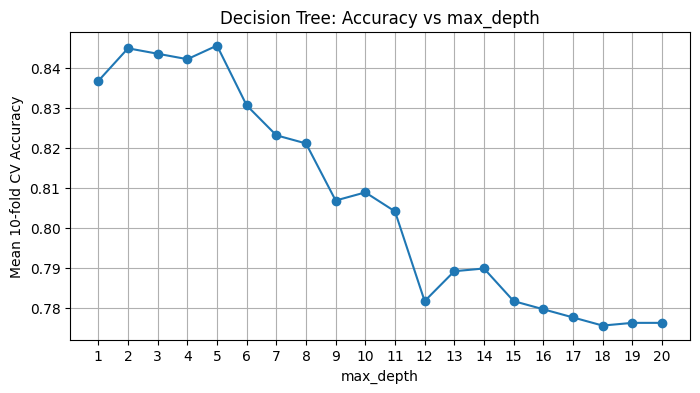

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depths, cv_means, marker="o")
ax.set_xlabel("max_depth")
ax.set_ylabel("Mean 10-fold CV Accuracy")
ax.set_title("Decision Tree: Accuracy vs max_depth")
ax.set_xticks(max_depths)
ax.grid(True)
plt.show()


## 4) Best tree vs ensembles
We compare cross-validated accuracy for:
- best single decision tree
- bagging
- random forest

In [8]:
# best single tree
best_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=best_depth)
scores_tree = cross_val_score(best_tree, X_all, y, cv=cv, scoring="accuracy")
print(f"Best single tree | mean CV acc: {scores_tree.mean():.4f} (std {scores_tree.std():.4f})")

# bagging
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=best_depth),
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
scores_bag = cross_val_score(bag, X_all, y, cv=cv, scoring="accuracy")
print(f"Bagging          | mean CV acc: {scores_bag.mean():.4f} (std {scores_bag.std():.4f})")

# random forest (single config)
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    max_depth=best_depth,
)
scores_rf = cross_val_score(rf, X_all, y, cv=cv, scoring="accuracy")
print(f"Random forest    | mean CV acc: {scores_rf.mean():.4f} (std {scores_rf.std():.4f})")


Best single tree | mean CV acc: 0.8456 (std 0.0175)
Bagging          | mean CV acc: 0.8585 (std 0.0128)
Random forest    | mean CV acc: 0.8531 (std 0.0106)


## 5) Random forests: sweep `n_estimators`
We vary the number of trees and plot mean CV accuracy.

In [9]:
n_estimators_list = [10, 25, 50, 100, 200, 300, 500]
rf_means = []

for n_est in n_estimators_list:
    model = RandomForestClassifier(
        n_estimators=n_est,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        max_depth=best_depth,
    )
    scores = cross_val_score(model, X_all, y, cv=cv, scoring="accuracy")
    rf_means.append(float(scores.mean()))

best_rf_idx = int(np.argmax(rf_means))
print(f"Best n_estimators = {n_estimators_list[best_rf_idx]} with mean CV acc = {rf_means[best_rf_idx]:.4f}")


Best n_estimators = 50 with mean CV acc = 0.8544


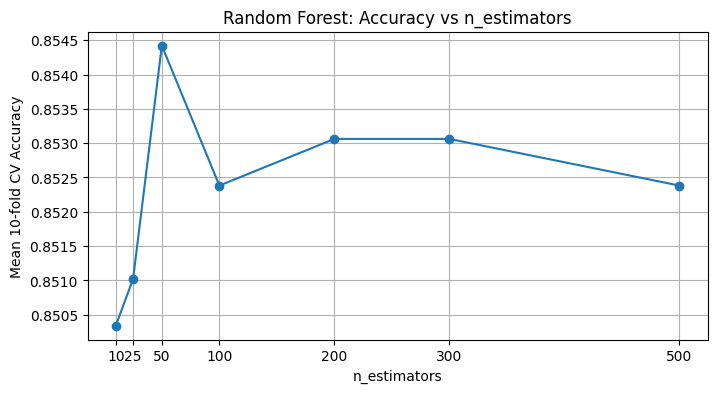

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(n_estimators_list, rf_means, marker="o")
ax.set_xlabel("n_estimators")
ax.set_ylabel("Mean 10-fold CV Accuracy")
ax.set_title("Random Forest: Accuracy vs n_estimators")
ax.set_xticks(n_estimators_list)
ax.grid(True)
plt.show()


## 6) Decision boundaries with 2 features (classification)
To visualize splits, we fit trees using **only two numeric features**.

We plot decision boundaries for different `max_depth` values on a **3×2** grid.

We prefer `Age` and `MonthlyIncome` if they exist; otherwise we use the first two numeric columns.

In [11]:
preferred = ["Age", "DistanceFromHome"]
two_features = [c for c in preferred if c in num_cols]

if len(two_features) < 2:
    two_features = num_cols[:2]

assert len(two_features) == 2, "Need two numeric features to plot decision boundaries."
print("Using features:", two_features)

X2 = X[two_features].to_numpy()
y2 = y.to_numpy()


Using features: ['Age', 'DistanceFromHome']


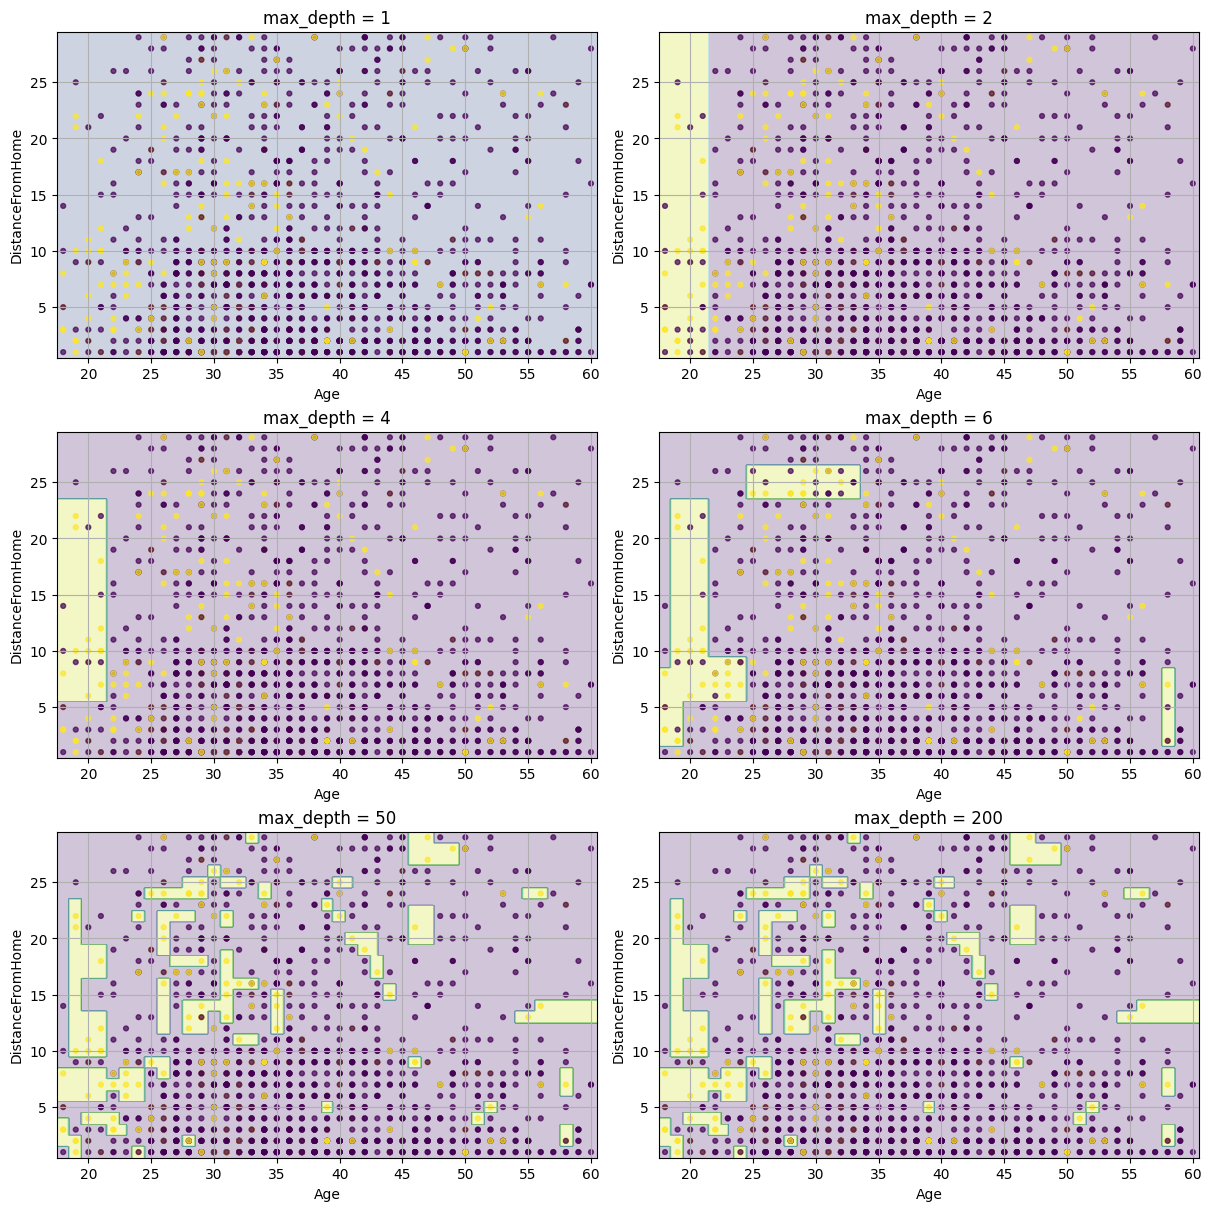

In [12]:
depth_grid = [1, 2, 4, 6, 50, 200]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), constrained_layout=True)
axes = axes.ravel()

x0 = X2[:, 0]
x1 = X2[:, 1]
x0_min, x0_max = x0.min() - 0.5, x0.max() + 0.5
x1_min, x1_max = x1.min() - 0.5, x1.max() + 0.5

xx, yy = np.meshgrid(
    np.linspace(x0_min, x0_max, 300),
    np.linspace(x1_min, x1_max, 300),
)
grid = np.c_[xx.ravel(), yy.ravel()]

for ax, d in zip(axes, depth_grid):
    clf2 = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=d)
    clf2.fit(X2, y2)

    Z = clf2.predict(grid).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.25)
    ax.scatter(x0, x1, c=y2, s=12, alpha=0.7)

    ax.set_xlabel(two_features[0])
    ax.set_ylabel(two_features[1])
    ax.set_title(f"max_depth = {d}")
    ax.grid(True)

plt.show()


## 7) Plot the fitted classification tree (2 features)
We plot a small tree (max_depth=3) using the same two features.

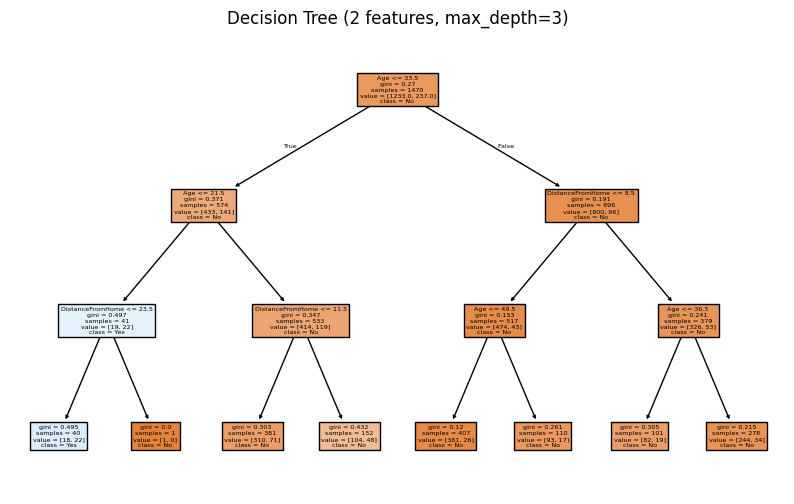

In [13]:
clf2 = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=3)
clf2.fit(X2, y2)

fig, ax = plt.subplots(figsize=(10, 6))
plot_tree(
    clf2,
    feature_names=two_features,
    class_names=["No", "Yes"],
    filled=True,
    impurity=True,
    ax=ax,
)
ax.set_title("Decision Tree (2 features, max_depth=3)")
plt.show()


## 8) Short regression tree example (built-in dataset)
We use scikit-learn's Diabetes dataset [read more here](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset).

- Target is continuous measure of disease progression over a year.
- Evaluate regression trees with 10-fold CV **R²**
- Sweep `max_depth` and plot mean CV R²
- Visualize a 2-feature regression surface and the tree

In [14]:
diabetes = load_diabetes(as_frame=True)
Xr = diabetes.data
yr = diabetes.target

cv_r = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

depths_r = list(range(1, 16))
r2_means = []

for d in depths_r:
    reg = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=d)
    scores = cross_val_score(reg, Xr, yr, cv=cv_r, scoring="r2")
    r2_means.append(float(scores.mean()))

best_r_idx = int(np.argmax(r2_means))
best_r_depth = depths_r[best_r_idx]

print(f"Best max_depth = {best_r_depth} with mean CV R² = {r2_means[best_r_idx]:.4f}")


Best max_depth = 2 with mean CV R² = 0.3253


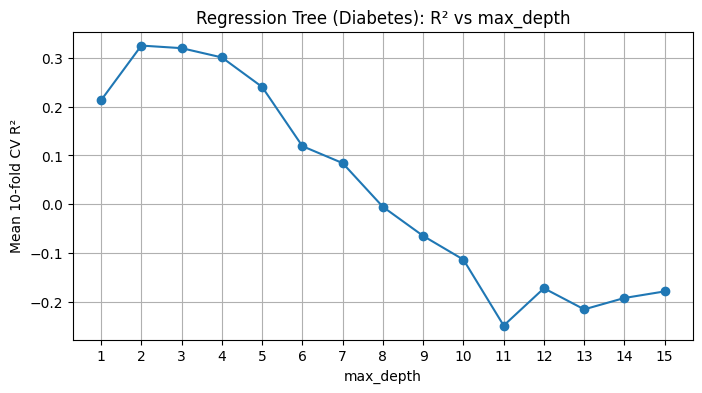

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(depths_r, r2_means, marker="o")
ax.set_xlabel("max_depth")
ax.set_ylabel("Mean 10-fold CV R²")
ax.set_title("Regression Tree (Diabetes): R² vs max_depth")
ax.set_xticks(depths_r)
ax.grid(True)
plt.show()


### Regression surface with 2 features
We visualize a regression tree trained on two features to see piecewise-constant predictions.

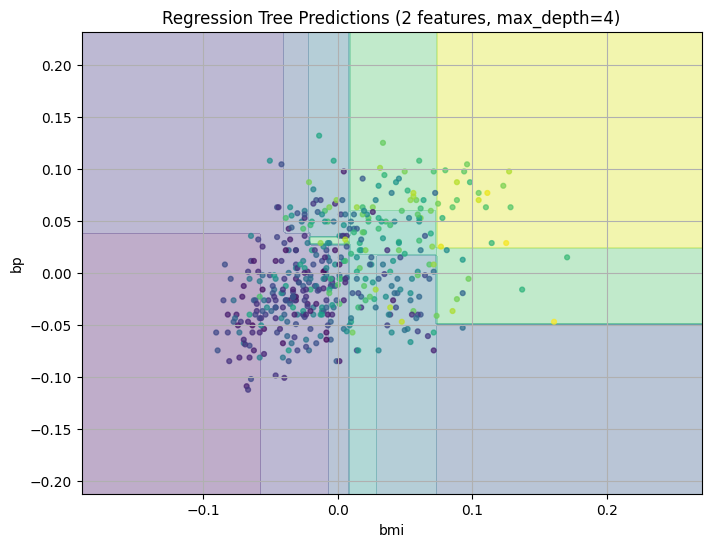

In [16]:
feat_r = ["bmi", "bp"]
if not all(f in Xr.columns for f in feat_r):
    feat_r = Xr.columns[:2].tolist()

Xr2 = Xr[feat_r].to_numpy()

reg2 = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=4)
reg2.fit(Xr2, yr.to_numpy())

x0 = Xr2[:, 0]
x1 = Xr2[:, 1]
x0_min, x0_max = x0.min() - 0.1, x0.max() + 0.1
x1_min, x1_max = x1.min() - 0.1, x1.max() + 0.1

xx, yy = np.meshgrid(
    np.linspace(x0_min, x0_max, 250),
    np.linspace(x1_min, x1_max, 250),
)
grid = np.c_[xx.ravel(), yy.ravel()]
preds = reg2.predict(grid).reshape(xx.shape)

fig, ax = plt.subplots(figsize=(8, 6))
ax.contourf(xx, yy, preds, alpha=0.35)
ax.scatter(x0, x1, c=yr, s=12, alpha=0.7)
ax.set_xlabel(feat_r[0])
ax.set_ylabel(feat_r[1])
ax.set_title("Regression Tree Predictions (2 features, max_depth=4)")
ax.grid(True)
plt.show()


### Plot the regression tree (2 features)
We plot the tree trained on the same two features.

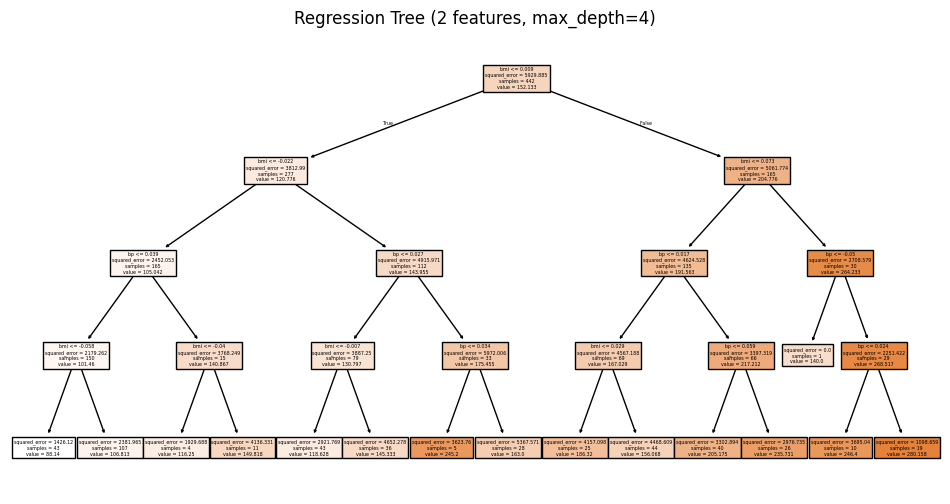

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_tree(
    reg2,
    feature_names=feat_r,
    filled=True,
    impurity=True,
    ax=ax,
)
ax.set_title("Regression Tree (2 features, max_depth=4)")
plt.show()
